# **Panorama Application using Image Stiching**


```
Christos Koromilas(i6345703)
```



In this assignment, I develop my own panorama application by stitching together pairs
of images.  I will show analytically results on one image pair but also visualize how the algorithm works on 2 or 3 more images.
My images will be "parallel" to each other to avoid perspective distortions.


# Notebook Setup

Import Libraries

In [ ]:
import os
import cv2
import random
from itertools import product
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive, files
from google.colab.patches import cv2_imshow

from skimage.morphology import octagon
from skimage.feature import corner_harris, corner_peaks, corner_orientations, corner_subpix
from skimage.transform import AffineTransform

Directory Paths and Mounting Drive (Google_Drive)

The folder in GoogleDrive:
```

```



Choose your main path:

In [ ]:
drive.mount(
    "/content/drive"
    , force_remount=True
    )

# Our Directory
main_directory_path = ""

# Your Directory
# main_directory_path = ""

Mounted at /content/drive


Directory Paths

In [ ]:
# Set the path to export plots in images directory
images_path = main_directory_path + "Data/Images/"

# Set the path to export plots in images directory
output_path = main_directory_path + "Data/Images/Output/"

# Image Acquisition

Available Images

In [ ]:
images_ex = [".jpg"]
images_f = [i for i in os.listdir(images_path) if ( i.endswith(".jpg") or i.endswith(".png") ) and i not in images_ex]
print(images_f)

['bryce_result_02a.jpg', 'bryce_result_02b.jpg', 'two_pov_l.jpg', 'two_pov_r.jpg']


Choose Images (PATHs)

In [ ]:
l_image_path = images_path+images_f[0]
r_image_path = images_path+images_f[1]

# Image Preprocessing

Load and Convert Images to Grayscale:

In [ ]:
l_image_rgb= cv2.imread(l_image_path, cv2.IMREAD_COLOR)
r_image_rgb= cv2.imread(r_image_path, cv2.IMREAD_COLOR)

l_image_gray = cv2.cvtColor(l_image_rgb, cv2.COLOR_BGR2GRAY)
r_image_gray = cv2.cvtColor(r_image_rgb, cv2.COLOR_BGR2GRAY)

Display Images (RGB & GRAY)

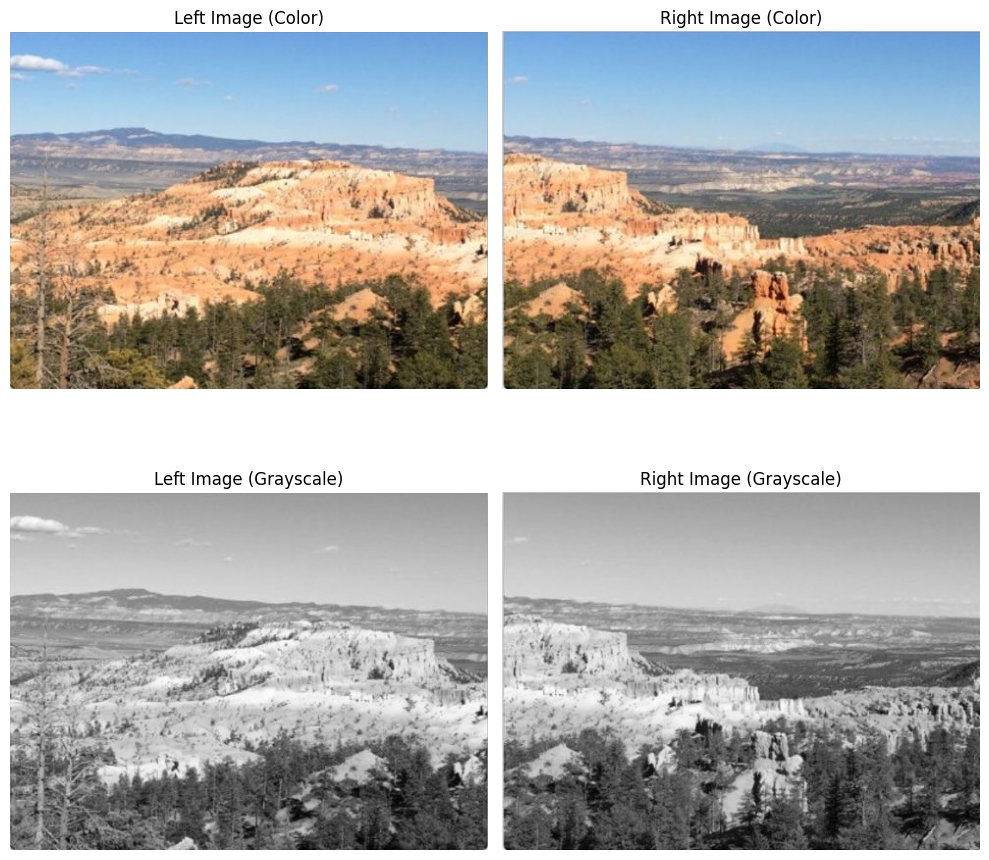

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axes[0, 0].imshow(cv2.cvtColor(l_image_rgb, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Left Image (Color)')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(r_image_rgb, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Right Image (Color)')
axes[0, 1].axis('off')

axes[1, 0].imshow(l_image_gray, cmap='gray')
axes[1, 0].set_title('Left Image (Grayscale)')
axes[1, 0].axis('off')

axes[1, 1].imshow(r_image_gray, cmap='gray')
axes[1, 1].set_title('Right Image (Grayscale)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(output_path + "Left_Right_Color_Grayscale.png", bbox_inches='tight', pad_inches=0)
plt.show()


# Feature Detection

## Harris Corner Detection and Orientations:



In [ ]:
def harris_corners_oriantations(gray_image, min_dist=1, threshold_rel=0.01):
    coordinates = corner_peaks(corner_harris(gray_image), min_distance=min_dist, threshold_rel=threshold_rel)
    orientations = np.rad2deg(corner_orientations(gray_image, coordinates, octagon(3, 2)))
    return coordinates, orientations


In [ ]:
l_coords, l_orients = harris_corners_oriantations(l_image_gray)
r_coords, r_orients = harris_corners_oriantations(r_image_gray)

# print("Left Image corners:\n", l_coords)
# print("Right Image corners:\n", r_coords)

Harris Corners Sensitivity

In [ ]:
def plot_corners(ax, image, coords):
    """
    Plots image and overlays Harris corners on an axis.
    """
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='red', marker='x', linestyle='None', markersize=10)

def plot_harris_sensitivity(ax, image, min_distance, threshold_rel):
    """
    Computes Harris corners and plots on given axis for a specific min_distance and threshold_rel.
    """
    coords, _ = harris_corners_oriantations(image, min_dist=min_distance, threshold_rel=threshold_rel)
    plot_corners(ax, image, coords)
    ax.set_title(f'Min Dist: {min_distance}, Threshold Rel: {threshold_rel}')

def harris_sensitivity(image, min_distances=[5, 10, 15], threshold_rels=[0.0001, 0.001, 0.01], title=""):
    """
    Plots Harris corners on a grid of subplots for different combinations of min_distance and threshold_rel.
    """
    if len(min_distances) == len(threshold_rels) == 1:
        fig, ax = plt.subplots(figsize=(15, 15))
        plot_harris_sensitivity(ax, image, min_distances[0], threshold_rels[0])
    else:
        fig, axes = plt.subplots(len(min_distances), len(threshold_rels), figsize=(15, 15))
        for ax, (min_dist, thresh) in zip(axes.flat, product(min_distances, threshold_rels)):
            plot_harris_sensitivity(ax, image, min_dist, thresh)

    plt.tight_layout()
    plt.savefig(output_path + "harris_sens_"+title+".png", bbox_inches='tight', pad_inches=0)
    plt.show()


Left Image

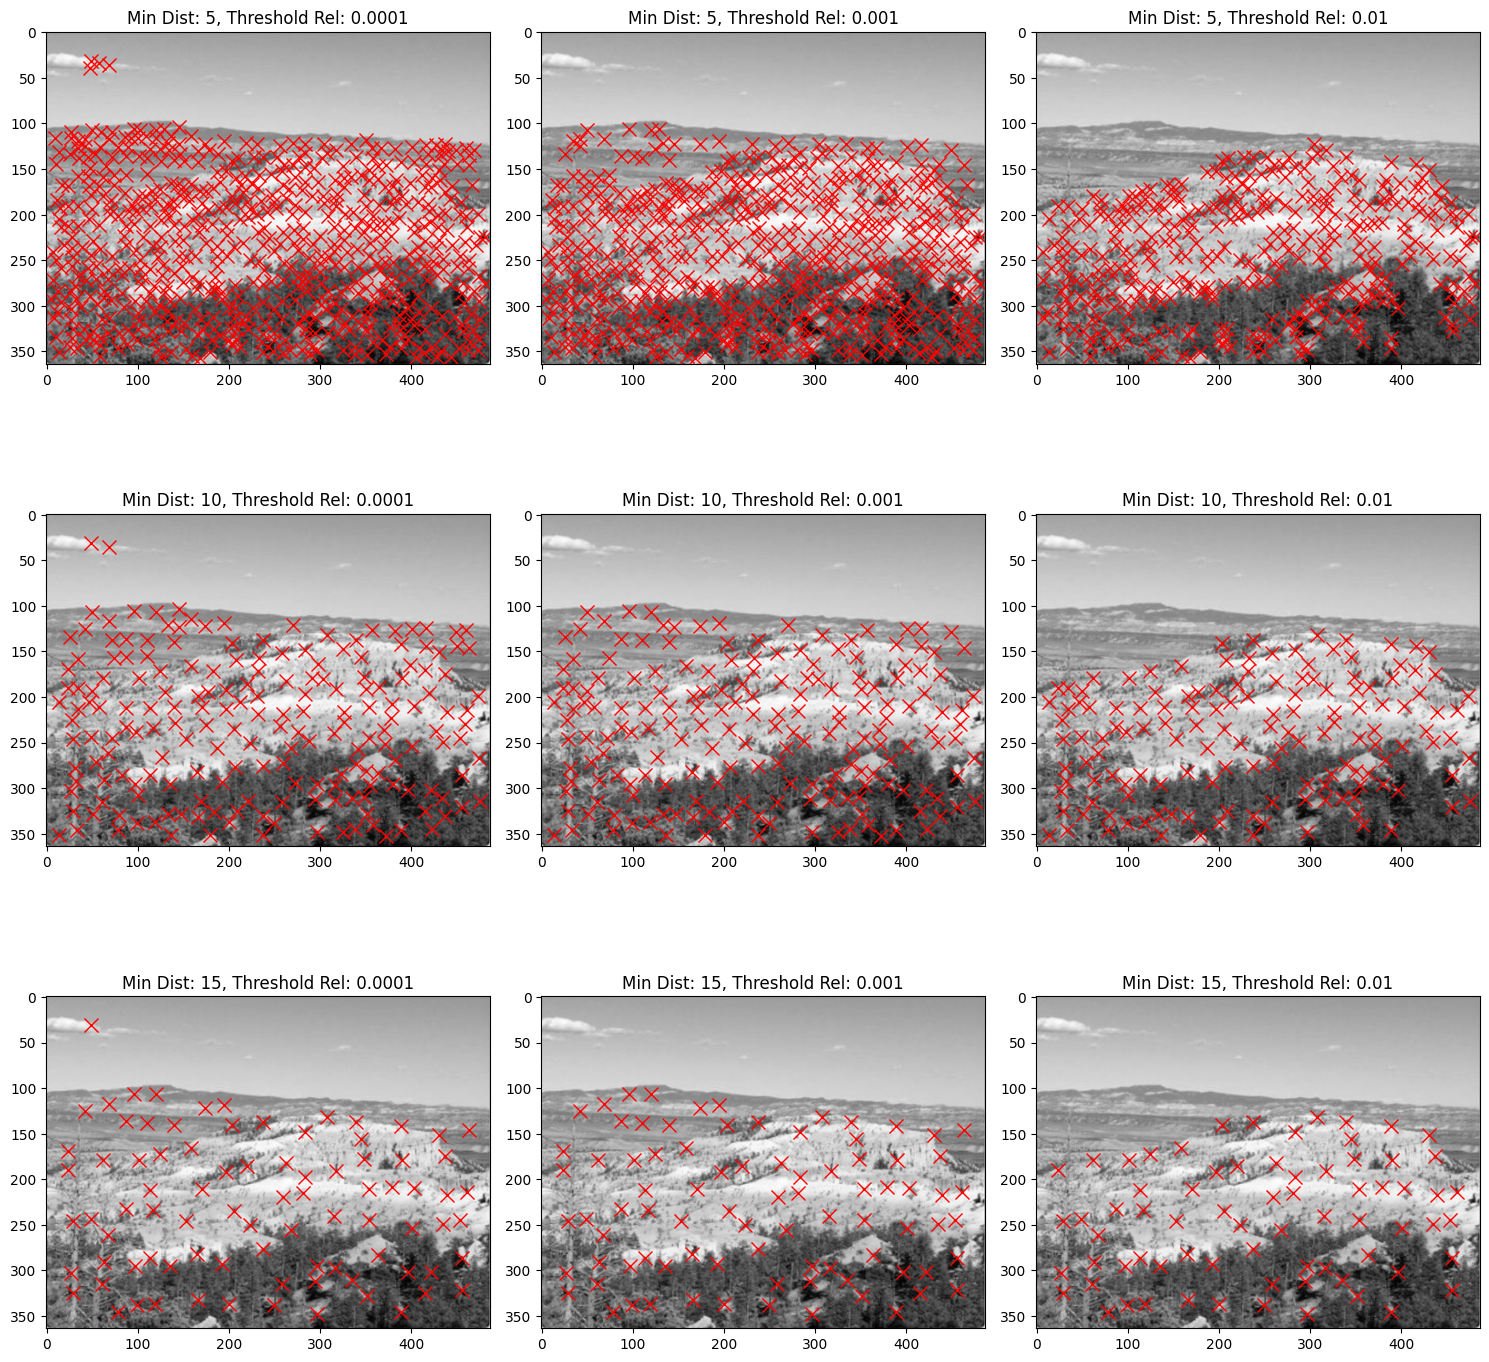

In [ ]:
harris_sensitivity(l_image_gray,title="left")

Right Image

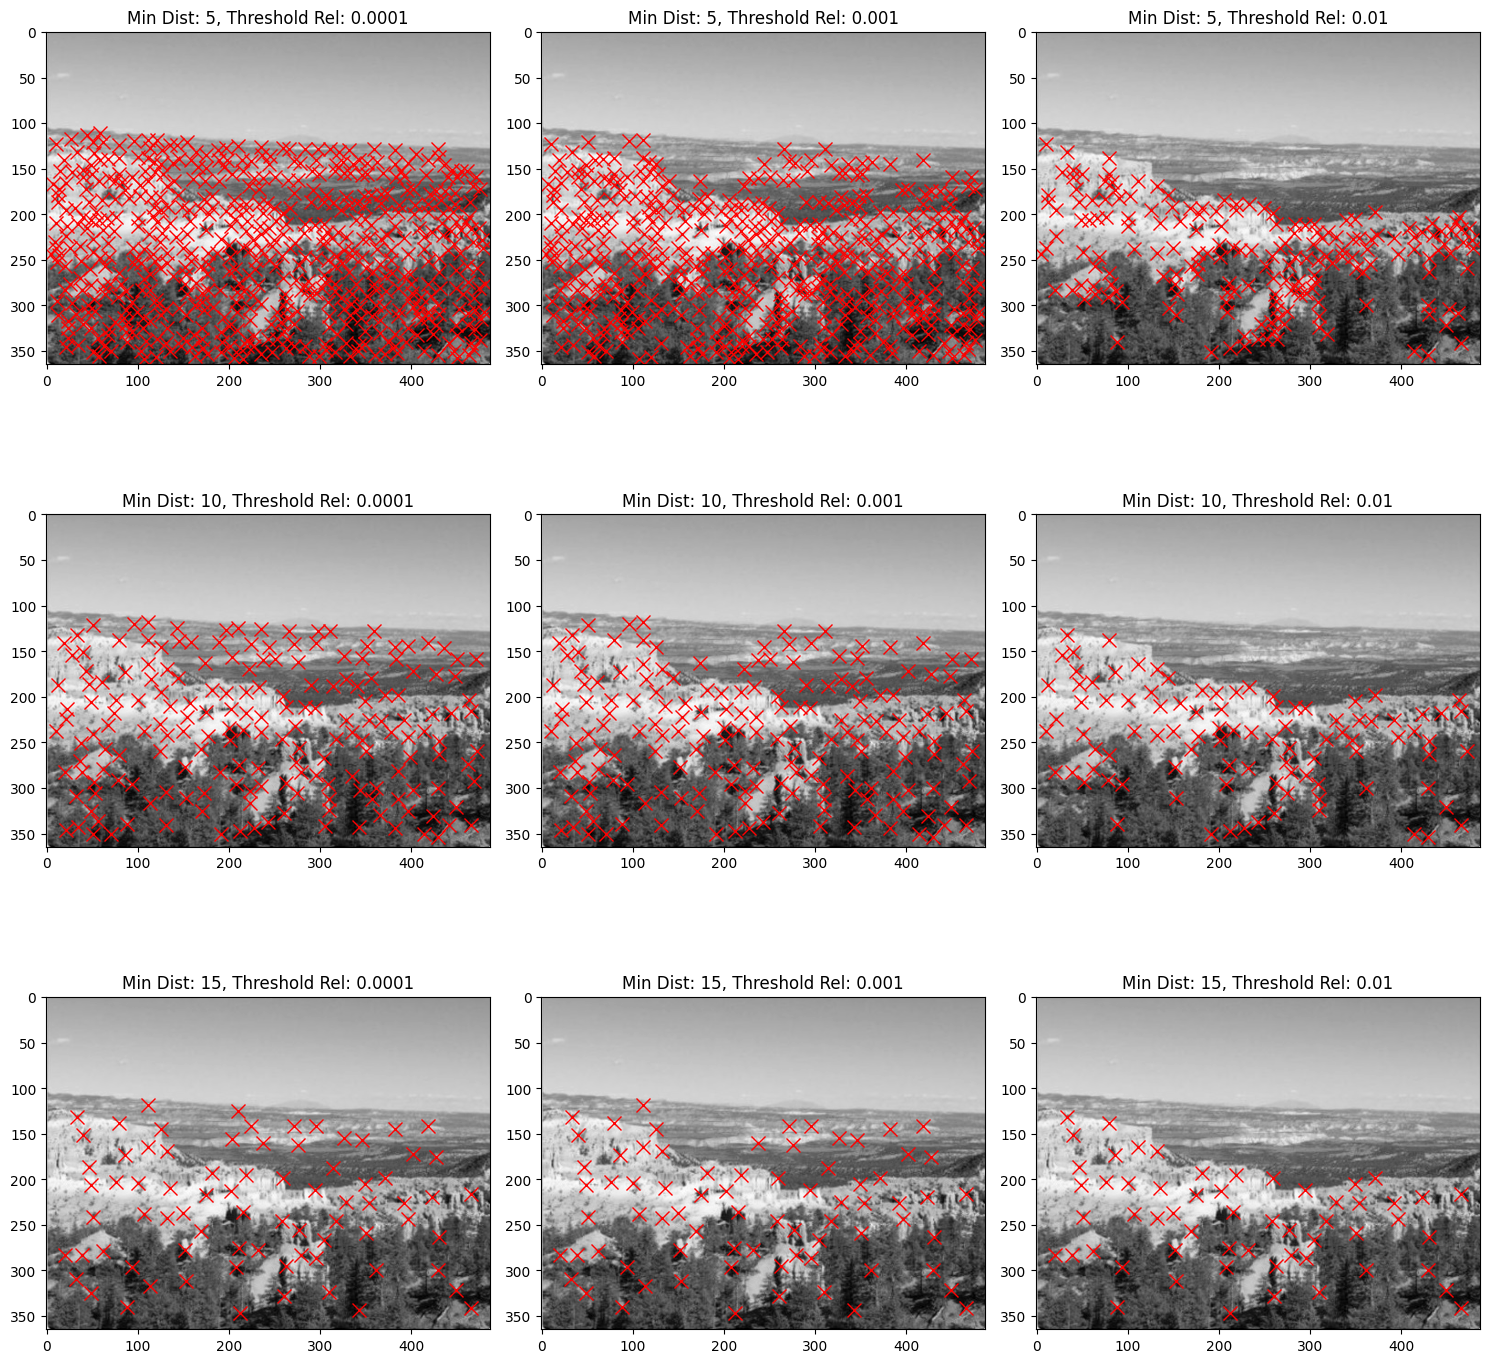

In [ ]:
harris_sensitivity(r_image_gray,title="right")

Best Combination of Harris Corner Detection

In [ ]:
min_dist = 15
thresh = 0.001

l_harris_keypoints, l_orients = harris_corners_oriantations(l_image_gray, min_dist=min_dist, threshold_rel=thresh)
r_harris_keypoints, r_orients = harris_corners_oriantations(r_image_gray, min_dist=min_dist, threshold_rel=thresh)

harris_sensitivity(l_image_gray, min_distances=[min_dist], threshold_rels=[thresh],title="left_chosen")
harris_sensitivity(r_image_gray, min_distances=[min_dist], threshold_rels=[thresh],title="right_chosen")


Output hidden; open in https://colab.research.google.com to view.

Detected Corners

In [ ]:
print("Corners detected on the left image: ",len(l_harris_keypoints))
print("Corners detected on the right image: ",len(r_harris_keypoints))

Corners detected on the left image:  85
Corners detected on the right image:  74


## Extract fixed-size patches around the corners

In [ ]:
patch_size = 15

In [ ]:
l_harris_keypoints = np.column_stack((l_harris_keypoints, l_orients))
r_harris_keypoints = np.column_stack((r_harris_keypoints, r_orients))

l_cv_keypoints = [cv2.KeyPoint(float(crd[1]),
                               float(crd[0]),
                               patch_size,
                               angle = int(crd[2])) for crd in l_harris_keypoints]

r_cv_keypoints = [cv2.KeyPoint(float(crd[1]),
                               float(crd[0]),
                               patch_size,
                               angle = int(crd[2])) for crd in r_harris_keypoints]

## SIFT Descriptor Computation and Visualization

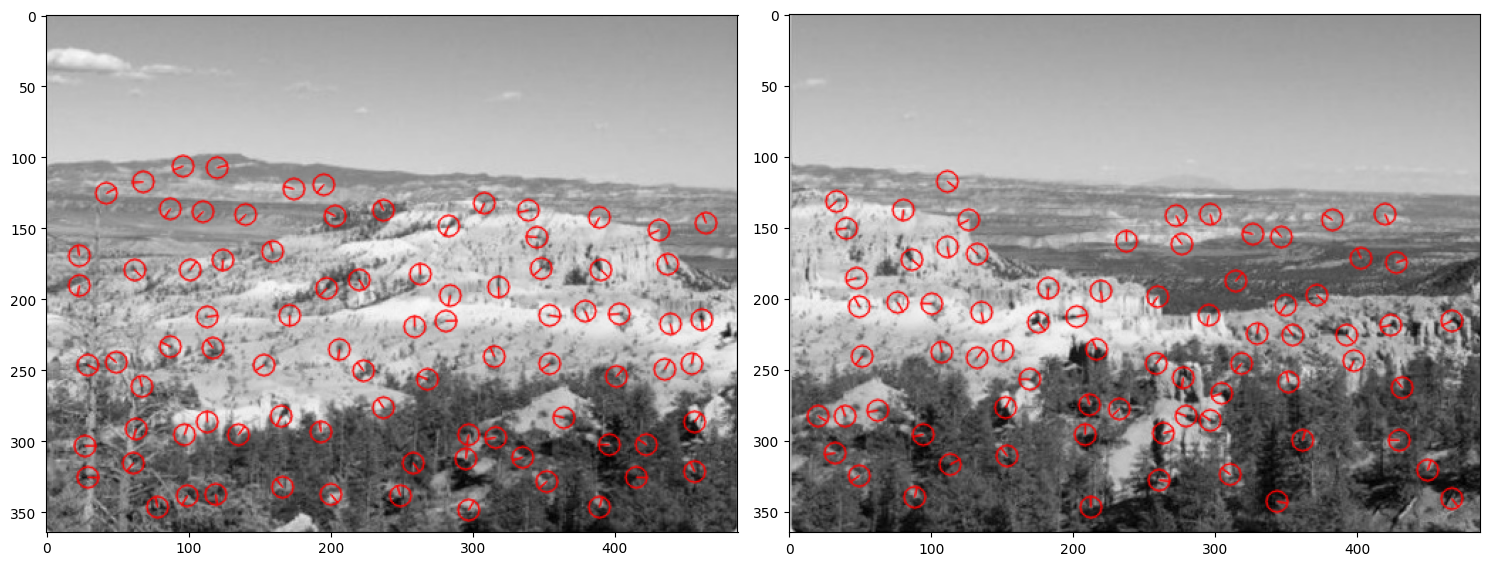

In [ ]:
sift = cv2.SIFT_create()

l_keypoints, l_descriptors = sift.compute(l_image_gray, l_cv_keypoints)
r_keypoints, r_descriptors = sift.compute(r_image_gray, r_cv_keypoints)

l_sift = cv2.drawKeypoints(l_image_gray,
                           l_keypoints,
                           l_image_rgb,
                           color=(255, 0, 0),
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

r_sift = cv2.drawKeypoints(r_image_gray,
                           r_keypoints,
                           r_image_rgb,
                           color=(255, 0, 0),
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(l_sift, cmap=plt.cm.gray)
ax2.imshow(r_sift, cmap=plt.cm.gray)
plt.tight_layout()
plt.savefig(output_path + "corners_of_the_images.png", bbox_inches='tight', pad_inches=0)
plt.show()

# Compute the Eyclidean Distance of all normalized Descriptor pairs

Normalized correlation is a measure of similarity between two sequences. A value of 1 indicates a perfect match, a value of 0 indicates no correlation, and a value of -1 indicates a perfect anti-correlation.

Euclidean Distance Calculation between SIFT Descriptors

In [ ]:
def euclidean_distance(sift1, sift2):
    index_pairs = []
    euclidean_distances = []
    sift1_normalized = sift1 / np.sqrt(np.sum(sift1**2, axis=1, keepdims=True))
    sift2_normalized = sift2 / np.sqrt(np.sum(sift2**2, axis=1, keepdims=True))

    for i, desc1 in enumerate(sift1_normalized):
        for j, desc2 in enumerate(sift2_normalized):
            index_pairs.append([i, j])
            dist = np.sqrt(np.sum((desc1 - desc2)**2))
            euclidean_distances.append(dist)

    return index_pairs, euclidean_distances

index_pairs, eucl_dist = euclidean_distance(l_descriptors, r_descriptors)


Heatmap

In [ ]:
# def euclidean_distance(sift1, sift2):
#     # normalize sift1 and sift2
#     sift1_normalized = sift1 / np.sqrt(np.sum(sift1**2, axis=1, keepdims=True))
#     sift2_normalized = sift2 / np.sqrt(np.sum(sift2**2, axis=1, keepdims=True))

#     euclidean_distances = np.zeros((sift1_normalized.shape[0], sift2_normalized.shape[0]))

#     for i, desc1 in enumerate(sift1_normalized):
#         for j, desc2 in enumerate(sift2_normalized):
#             euclidean_distances[i,j] = np.sqrt(np.sum((desc1 - desc2)**2))

#     return euclidean_distances

# eucl_dist = euclidean_distance(l_descriptors, r_descriptors)

# # Use matplotlib to create a heatmap
# plt.imshow(eucl_dist, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()


Sort Euclidean Distances and Index Pairs

In [ ]:
def sort_distances(index_pairs, distances):
    index_pairs = np.array(index_pairs)
    distances = np.array(distances)

    inds = distances.argsort()

    sorted_distances = distances[inds]
    sorted_index_pairs = index_pairs[inds]

    return sorted_index_pairs, sorted_distances

sorted_index_pairs, sorted_eucl_dist = sort_distances(index_pairs, eucl_dist)


print("Sorted Euclidean distances (3 lowest):")
print(sorted_eucl_dist[:3])
print("\nSorted corner pairs based on their descriptor distances (3 best matches):")
print(sorted_index_pairs[:3])


Sorted Euclidean distances (3 lowest):
[0.05855431 0.08831978 0.10446537]

Sorted corner pairs based on their descriptor distances (3 best matches):
[[ 1  2]
 [63 60]
 [51 52]]


Select the best matched by considering only the top few paors of descriptors based on their Euclidian distance

In [ ]:
def select_unique_matches(sorted_index_pairs, num_pairs=1000):
    left_points = set()
    right_points = set()

    matches = []

    for pair in sorted_index_pairs[:num_pairs]:
        left, right = pair[0], pair[1]

        if left not in left_points and right not in right_points:
            matches.append((left, right))
            left_points.add(left)
            right_points.add(right)

    return matches, len(matches)

matches, num_matches = select_unique_matches(sorted_index_pairs)
print("Total matches selected: ", num_matches)


Total matches selected:  63


New Keypoints Based on Matches

In [ ]:
l_new_keypoints = [l_keypoints[i] for i, _ in matches]
r_new_keypoints = [r_keypoints[j] for _, j in matches]

Show the Best Matches

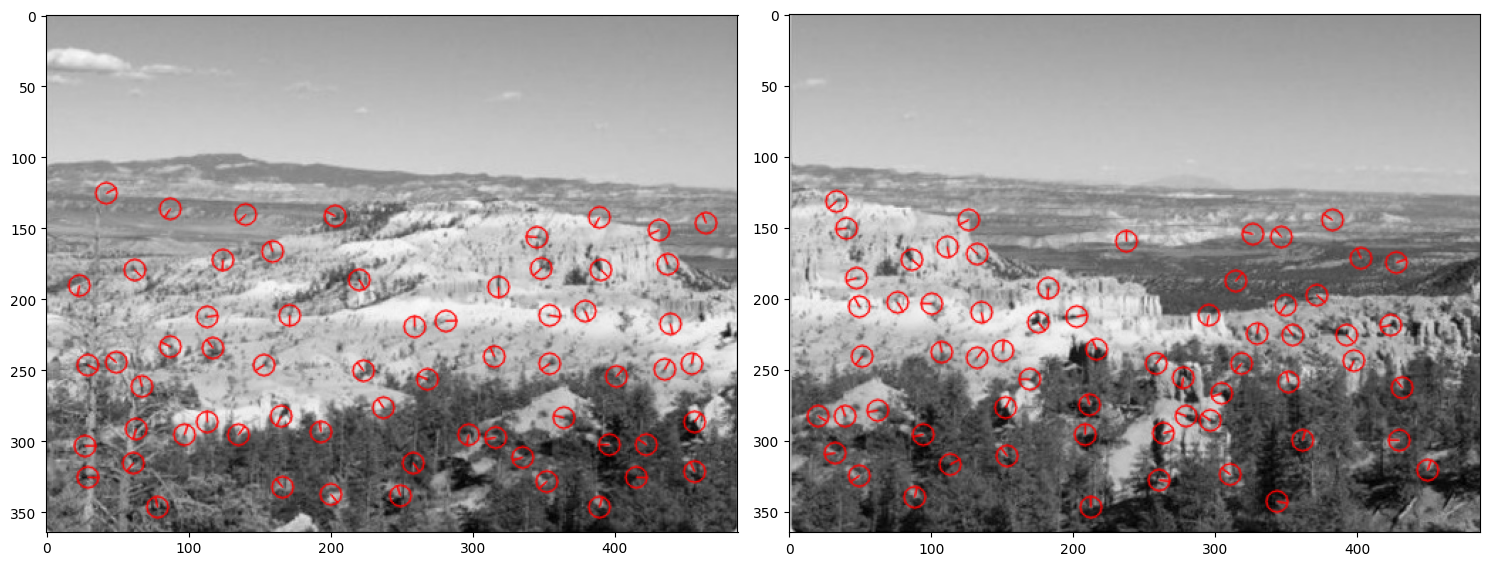

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

l_sift = cv2.drawKeypoints(l_image_gray,
                           l_new_keypoints,
                           l_image_rgb,
                           color=(255, 0, 0),
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

r_sift = cv2.drawKeypoints(r_image_gray,
                           r_new_keypoints,
                           r_image_rgb,
                           color=(255, 0, 0),
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

ax1.imshow(l_sift, cmap=plt.cm.gray)
ax2.imshow(r_sift, cmap=plt.cm.gray)
plt.tight_layout()
plt.savefig(output_path + "chosen_matches.png", bbox_inches='tight', pad_inches=0)
plt.show()

# Ransac

RANSAC Algorithm for Affine Transformation Estimation (My implementation)

In [ ]:
def RANSAC(kpsA: List, kpsB: List, matches: List, iterations: int = 10, init_matches: int = 3, verbose: bool = False) -> Tuple[np.array, float, int]:
    """
    Performs RANSAC algorithm to find the best affine transformation.
    """

    # Checks
    assert init_matches <= len(matches), 'init_matches should be less than or equal to the total number of matches'
    assert iterations > 0, 'iterations should be greater than 0'

    lowest_dist = np.inf
    lowest_H = None
    max_inliers = 0

    for i in range(iterations):
        if verbose: print(f"Iteration: {i}")

        sample = random.sample(matches, init_matches)
        ptsA = np.float32([kpsA[i][:2] for (_, i) in sample])
        ptsB = np.float32([kpsB[i][:2] for (i, _) in sample])

        H, status = cv2.estimateAffine2D(ptsA, ptsB)  # Using estimateAffine2D
        if H is None:  # If no transformation could be estimated, continue to the next iteration
            continue
        if verbose:
            print("\nAffine transformation:")
            print(H)

        n_ptsA = np.float32([kpsA[i][:2] for (_, i) in matches])
        n_ptsB = np.float32([kpsB[i][:2] for (i, _) in matches])

        transformed_pts = cv2.transform(np.array([n_ptsA]), H)[0]  # Transform n_ptsA using the estimated affine transformation

        sq_d = np.sum(np.square(transformed_pts - n_ptsB))  # Compute the squared distance
        inliers = np.sum(status)  # Count the number of inliers

        if verbose:
            print("Squared Distance:", sq_d)
            print('Inliers:', inliers)
            print('-----------')

        if sq_d < lowest_dist:
            lowest_dist = sq_d
            lowest_H = H
            max_inliers = inliers

    return matches, lowest_H, lowest_dist, max_inliers


matches, H, dist, inl = RANSAC(r_harris_keypoints, l_harris_keypoints, matches, iterations=100, init_matches=5, verbose=True)


Iteration: 0

Affine transformation:
[[-6.20000000e+01  1.12530120e+01  1.75962169e+04]
 [ 1.09000000e+02 -2.20722892e+01 -2.97932048e+04]]
Squared Distance: 10172110000.0
Inliers: 3
-----------
Iteration: 1

Affine transformation:
[[ 1.10033585e+00 -2.82415737e-01  2.40555955e+01]
 [-2.36985726e+00 -4.71812403e-01  1.00036470e+03]]
Squared Distance: 2645947.8
Inliers: 3
-----------
Iteration: 2

Affine transformation:
[[  1.05527225   0.08619839 -20.3780227 ]
 [  1.000658     1.47721665 -81.21878598]]
Squared Distance: 9105354.0
Inliers: 3
-----------
Iteration: 3

Affine transformation:
[[-3.41916168e+00 -1.32035928e+00  1.62470659e+03]
 [ 5.46407186e+00  8.36826347e-01 -1.54242515e+03]]
Squared Distance: 24310580.0
Inliers: 3
-----------
Iteration: 4

Affine transformation:
[[ 6.72258136e-01  5.24409273e-02  7.43913843e+01]
 [ 3.46856888e-01 -9.42933571e-01  3.33341953e+02]]
Squared Distance: 1586194.2
Inliers: 3
-----------
Iteration: 5

Affine transformation:
[[ 1.79844607e-01  7.

In [ ]:
print("Best transformation: ",H)
print()
print("Squared distance: ",dist)
print()

Best transformation:  [[ 8.76744787e-01 -2.83732552e-01  5.69608392e+01]
 [ 4.63696938e-02 -4.52036303e-01  3.59079628e+02]]

Squared distance:  1372313.1



Ransac Point Matching and Homography Calculation (using OpenCV)



In [ ]:
def match_keypoints(keypointsA, keypointsB, featuresA, featuresB, matches, reprojection_threshold):
    if len(matches) > 4:
        ptsA = np.float32([keypointsA[i][:2] for (_, i) in matches])
        ptsB = np.float32([keypointsB[i][:2] for (i, _) in matches])

        homography, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojection_threshold)
        return (matches, homography, status)
    else:
        print("Insufficient matches for homography calculation")
        return None, None, None

harris_keypoints_ll = [[float(coord[1]), float(coord[0])] for coord in l_harris_keypoints]
harris_keypoints_rr = [[float(coord[1]), float(coord[0])] for coord in r_harris_keypoints]

matches, H, status = match_keypoints(harris_keypoints_rr, harris_keypoints_ll, r_descriptors, l_descriptors, matches, reprojection_threshold=5.0)


Final Homography

In [ ]:
H

array([[ 8.13280817e-01, -2.29235736e-02,  3.10058151e+02],
       [-5.42978508e-02,  9.57997840e-01,  1.11941783e+01],
       [-3.73487614e-04, -1.99081301e-05,  1.00000000e+00]])

Ransac: Display inliers (Drawing Matches between Images)

In [ ]:
def draw_matches(imageA, imageB, keypointsA, keypointsB, matches, status):
    heightA, widthA = imageA.shape[:2]
    heightB, widthB = imageB.shape[:2]

    visualization = np.zeros((max(heightA, heightB), widthA + widthB, 3), dtype="uint8")
    visualization[0:heightA, 0:widthA] = imageA
    visualization[0:heightB, widthA:] = imageB

    for ((query_index, train_index), match_status) in zip(matches, status):

        if match_status == 1:
            pointA = (int(keypointsA[query_index][0]), int(keypointsA[query_index][1]))
            pointB = (int(keypointsB[train_index][0]) + widthA, int(keypointsB[train_index][1]))

            cv2.line(visualization, pointA, pointB, (0, 255, 0), 1)

    return visualization

visualization = draw_matches(l_image_rgb,r_image_rgb,harris_keypoints_ll, harris_keypoints_rr, matches,status)



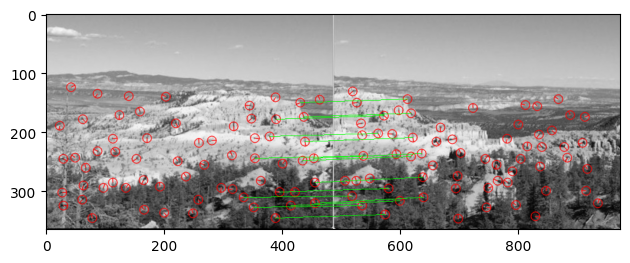

In [ ]:
plt.imshow(visualization)
plt.tight_layout()
plt.savefig(output_path + "matches_of_the_images.png", bbox_inches='tight', pad_inches=0)
plt.show()

## Wrap Image 1 into Image 2

Warping and Stitching Images

In [ ]:
l_image_rgb = cv2.imread(l_image_path, cv2.IMREAD_COLOR)
r_image_rgb = cv2.imread(r_image_path, cv2.IMREAD_COLOR)

In [ ]:
result = cv2.warpPerspective(r_image_rgb, H,(l_image_rgb.shape[1] + r_image_rgb.shape[1], r_image_rgb.shape[0]))
result[0:l_image_rgb.shape[0], 0:l_image_rgb.shape[1]] = l_image_rgb

Displaying the Warped Image

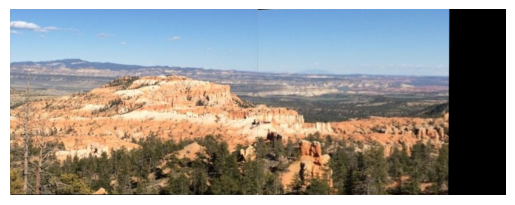

In [ ]:
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

cv2.imwrite(output_path + "wraped_images.png", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

plt.imshow(result)
plt.axis('off')
plt.show()

Plotting the Final Image

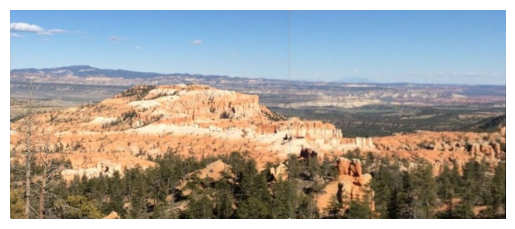

In [ ]:
non_zero_pixels = np.nonzero(np.any(result != [0, 0, 0], axis=-1))
min_y, max_y = np.min(non_zero_pixels[0]), np.max(non_zero_pixels[0])
min_x, max_x = np.min(non_zero_pixels[1]), np.max(non_zero_pixels[1])

cropped_result = result[min_y:max_y, min_x:max_x]

plt.imshow(cropped_result)
plt.axis('off')
plt.savefig(output_path + "final_image.png", bbox_inches='tight', pad_inches=0)
plt.show()


# Accuracy Score (Average Euclidean Distance)

In [ ]:
valid_matches = [(harris_keypoints_ll[i], harris_keypoints_rr[j]) for ((i, j), s) in zip(matches, status) if s == 1]
dist = np.sum([np.linalg.norm(np.dot(H, np.append(p, 1).T)[:2] - np.append(q[0] + l_image_rgb.shape[1], q[1])) for p, q in valid_matches])
accuracy_score = int(dist / len(valid_matches))

print("Accuracy Score (Average Euclidean Distance):", accuracy_score)


Accuracy Score (Average Euclidean Distance): 47
